# contado de mamões

Vamos importar as bibliotecas necessarias, é preciso instalar o torch 2.5.0 e o torch vision 0.11.2 e para GPU o cuda 11.3, 

In [2]:
import os
import torch
import torchvision
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

import neptune
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.ops import box_iou

Vamos dar uma olhada nas anotações e no problema a seguir

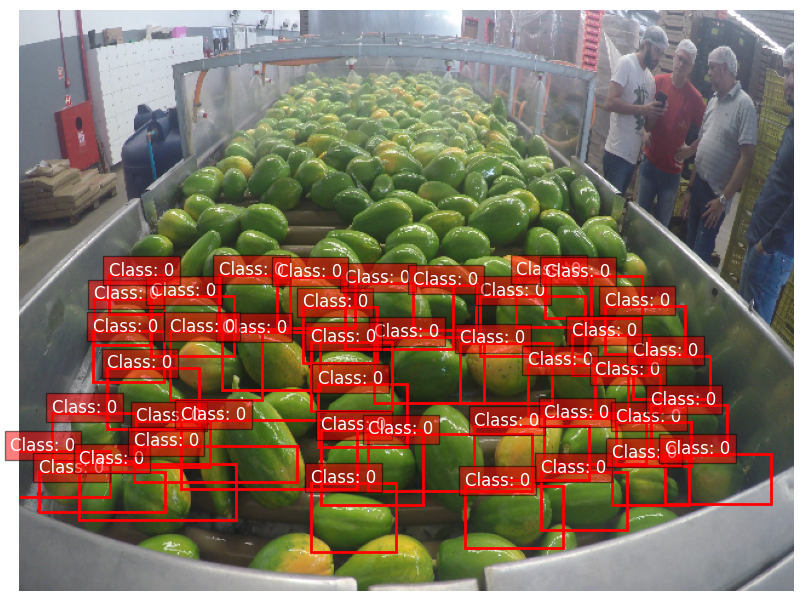

In [7]:
def load_labels(label_path):
    boxes = []
    with open(label_path, 'r') as file:
        for line in file:
            class_number, x, y, h, w = map(float, line.split())
            boxes.append((class_number, x, y, h, w))
    return boxes

def visualize_image_with_boxes(image_path, label_path):
    image = Image.open(image_path).convert("RGB")
    boxes = load_labels(label_path)

    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    ax = plt.gca()

    for class_number, x, y, h, w in boxes:
        # Assuming x, y, h, w are normalized, adjust them to image size
        img_width, img_height = image.size
        xmin = (x - w / 2) * img_width
        ymin = (y - h / 2) * img_height
        width = w * img_width
        height = h * img_height

        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(xmin, ymin, f'Class: {int(class_number)}', color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

    plt.axis('off')
    plt.show()

# Example usage
image_path = r'dataset\train\images\52.png'
label_path = r'dataset\train\labels\52.txt'
visualize_image_with_boxes(image_path, label_path)

Os objetos foram anotados só até certo ponto da imagem o que pode ser problematico, poderiamos cortar a imagem baseado na tamanho da presente, como foi feito na imagem do desafio, vamos testar e depois descobrir se isso é necessario

Vamos definir um dataloader, dois aspectos a se notar aqui:
- a classe 0 não pode ser usada nesse modelo, o numero 0 é reservado para background, então chamamos ela de classe 1
- o formato das anotações precisa ser convertido para xmin, ymin, xmax, ymax

In [2]:

class CustomDataset(Dataset):
    def __init__(self, img_dir, annotation_dir, transforms=None):
        self.img_dir = img_dir
        self.annotation_dir = annotation_dir
        self.transforms = transforms
        self.images = os.listdir(img_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        img = Image.open(img_path).convert("RGB")
        annotation_path = os.path.join(self.annotation_dir, self.images[idx].replace(".png", ".txt"))

        boxes = []
        labels = []

        with open(annotation_path) as f:
            for line in f:
                data = line.strip().split()
                class_id = int(data[0]) + 1
                x_center, y_center, width, height = map(float, data[1:])
                
                img_width, img_height = img.size
                xmin = int((x_center - width / 2) * img_width)
                ymin = int((y_center - height / 2) * img_height)
                xmax = int((x_center + width / 2) * img_width)
                ymax = int((y_center + height / 2) * img_height)

                boxes.append([xmin, ymin, xmax, ymax])
                labels.append(class_id)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {"boxes": boxes, "labels": labels}

        if self.transforms:
            img = self.transforms(img)

        return img, target
            

Definindo algumas funções auxiliares, vamos usar o MAE pois ele garante que a unidade de erro é a mesma, dai saberemos por quantos objetos o modelo está errando

In [3]:
def collate_fn(batch):
    return tuple(zip(*batch))

def mean_absolute_error(y_true, y_pred):
    # Ensure the lists are the same length
    assert len(y_true) == len(y_pred), "Lists must have the same length"
    
    # Calculate the MAE
    mae = sum(abs(yt - yp) for yt, yp in zip(y_true, y_pred)) / len(y_true)
    return mae

O codigo de eval no dataset de teste, procurei usar algumas metricas interessantes:
- o iou medio, para ter uma noção se as bounding box estão relamente se encaixando com a previsão, mas isso não foi bem observado nos treinos, resultando em valores iou bem pequeno.
- mais interessante e classica é avaliação da loss no dataset de teste.
- por fim o erro medio absoluto da quantidade de objetos detectados, pois no fim, o objetivo desse modelo é contar os objetos e não determinar as bb.

In [4]:

def evaluate_model(model, test_loader, device, iou_threshold=0.5):
    total_iou, total_images, total_boxes = 0, 0, 0
    total_loss = 0.0
    real_total_boxes, pred_total_boxes = [], []

    with torch.no_grad():
        for images, targets in test_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            model.train()
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            total_loss += losses.item() # calcula loss

            model.eval()
            outputs = model(images)
            
            for i, output in enumerate(outputs):
                pred_boxes = output['boxes']
                true_boxes = targets[i]['boxes']

                real_total_boxes.append(len(true_boxes)) #salva os valores para fazer o mae
                pred_total_boxes.append(len(pred_boxes))

                if len(pred_boxes) > 0 and len(true_boxes) > 0:
                    iou = box_iou(pred_boxes, true_boxes).mean().item()
                    total_iou += iou #calcula o iou das bbs previstas
                total_images += 1
    
    avg_iou = total_iou / total_images if total_images > 0 else 0
    avg_loss = total_loss / len(test_loader) if len(test_loader) > 0 else 0
    mae = mean_absolute_error(real_total_boxes, pred_total_boxes)
    
    print(f"Avg IoU: {avg_iou:.4f}")
    print(f"Avg Loss: {avg_loss:.4f}")
    print("Mean Absolute Error: ", mae)
    
    return avg_iou, avg_loss, mae


È interessante acompanahr o treinamento de alguma maneira, eu normalmente uso [neptune](https://neptune.ai/), netão precisamos configurar a nossa chave para ser usada nesse treino

In [ ]:
# Vamos usar neptune para logar os treinos e conseguir acompanhar
run = neptune.init_run(
    project="dmp/papaya",
    api_token="", #chave privada
)

Vamos preparar os parametros de treino, sem usar nada exagerado, uma simples lr de 0.005 deve servir

In [ ]:
# Para registrar hiperparâmetros (opcional)
parameters = {
    "threshold": 0.3,
    "batch_size": 4,
    "learning_rate": 0.005,
    "momentum": 0.9,
    "weight_decay": 0.0005,
    "num_epochs": 100,
}

run['parameters'] = parameters

é uma boa hora para verificar se o CUDA está disponivel durante o treino

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"CUDA is available. Running on {device}.")

Eu separei essa parte para fazer as transformações antes de colocar no modelo, é onde se faria augmentation também, mas acredito que não foi necessario

In [25]:
# Augmentations
train_transforms = T.Compose([
    T.ToTensor(),
])

test_transforms = T.Compose([
    T.ToTensor(),
])

Aqui vamos criar o DataLoader, esse valores podem ser ajustados de acordo com a quantidade de vram disponivel, note que o CustomDataset espera um formato de dataset um pouco diferente do que foi fornecido.
Criamos o collate_fn também para lidar a entrada de tamanho varaivel

In [ ]:
# Load dataset
train_dataset = CustomDataset(img_dir="dataset/train/images", annotation_dir="dataset/train/labels", transforms=train_transforms)
test_dataset = CustomDataset(img_dir="dataset/test/images", annotation_dir="dataset/test/labels", transforms=test_transforms)

# DataLoader with num_workers > 0
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=0, collate_fn=collate_fn)

Vamos instanciar o modelo e o otimizador

Usaremos o fasterrcnn_resnet50_fpn, os modelos faster cnn são muito bons por sua velocidade e precisão além de terem implementação facilidade no pytorch

In [26]:
# Model, optimizer, and other setup
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
  # Change this to your number of classes
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.score_thresh = parameters["threshold"]  
num_classes = 2
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.to(device)

optimizer = torch.optim.SGD([p for p in model.parameters() if p.requires_grad], lr=parameters["learning_rate"], 
                            momentum=parameters["momentum"], weight_decay=parameters["weight_decay"])



In [ ]:
num_epochs = 100

Finalmente o treino não possuei nada de especial, salvamos a loss a cada epoca no neptune e computamos o eval ao final de cada epoca. Além disso, salvamos o modelo a cada epoca para garantir poder ver o grafico no neptune e escolher o melhor 

Esse codigo vai salvar muitos modelos em uma pasta chamad modelos, certifique-se de que aespaço para isso e que a pasta existe

In [ ]:

if __name__ == '__main__':
    for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0

            for images, targets in train_loader:
                images = list(image.to(device) for image in images)
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

                loss_dict = model(images, targets)
                losses = sum(loss for loss in loss_dict.values())
                running_loss += losses.item()

                optimizer.zero_grad()
                losses.backward()
                optimizer.step()

            run["train/loss"].log(running_loss/len(train_loader))
            print(f"Epoch {epoch}, Loss: {running_loss/len(train_loader)}")

            # Evaluate the model after each epoch
            print(f"Evaluating after Epoch {epoch}...")
            avg_iou, avg_loss, mae = evaluate_model(model, test_loader, device, parameters["threshold"])
            run["test/IoU"].log(avg_iou)
            run["test/avg_loss"].log(avg_loss)
            run["test/mae"].log(mae)

            # Save the model after each epoch
            save_path = f"modelos/model_epoch_{epoch}.pth"
            torch.save(model.state_dict(), save_path)
            print(f"Model saved at {save_path}")


    run.stop()

Eu não deixei rodando as 100 epocas, pois acredito não tenho mais tempo o desafio é menos de 48 horas, temos o seguinte grafico:

![Alt text](assets/train_loss.png "a title")  ![Alt text](assets/test_loss.png "a title") 

Da para ver que a loss ainda não se estabilizou completamente e a loss de treino ainda não está piorando, então poderiamos ter treinado por mais algumas epocas, entranto olhando o erro medio absoluto vemos que isso provavelmente não vai ser mais necessario:


![Alt text](assets/mae.png "grafico erro medio absoluto")

Variando com valores abaixo de 1 (0.5), quer dizer que o modelo no dataset de teste inteiro tem a media de erro de meio mamão é bem pouco 

Esses graficos podem ser acessados por algum tempo no link publico do [neptune](https://app.neptune.ai/dmp/papaya/runs/details?viewId=standard-view&detailsTab=charts&shortId=MAN-9&type=run)

Seguindo essa tendencia, vamos pegar o ultimo modelo treinado, no caso o da época 42 e fazer a inferencia do desafio nele

Antes vamos criar algumas funções auxiliares, apenas para ajudar a printar o resultado na tela

In [27]:
def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    transform = T.ToTensor()
    return transform(image).unsqueeze(0)

def visualize_predictions(image_path, predictions, threshold=0.5):
    image = Image.open(image_path).convert("RGB")
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    ax = plt.gca()

    counter = 0
    for box, score in zip(predictions['boxes'], predictions['scores']):
        if score >= threshold:
            counter += 1
            xmin, ymin, xmax, ymax = box.cpu().numpy()
            width, height = xmax - xmin, ymax - ymin
            rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(xmin, ymin, f'{score:.2f}', color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

    ax.text(10, 10, f'numero de mamões encontrados: {counter}', color='white', fontsize=16, bbox=dict(facecolor='black', alpha=0.5))

    plt.axis('off')
    plt.show()

Vamos carregar o modelo

In [24]:
model_path = r"modelos\model_epoch_42.pth"

In [25]:
# vou repetir algumas linhas aqui caso se queira rodar a partir daqui
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.load_state_dict(torch.load("modelos\model_epoch_42.pth"))  
model.eval().to(device)
print("modelo caregado")

modelo caregado


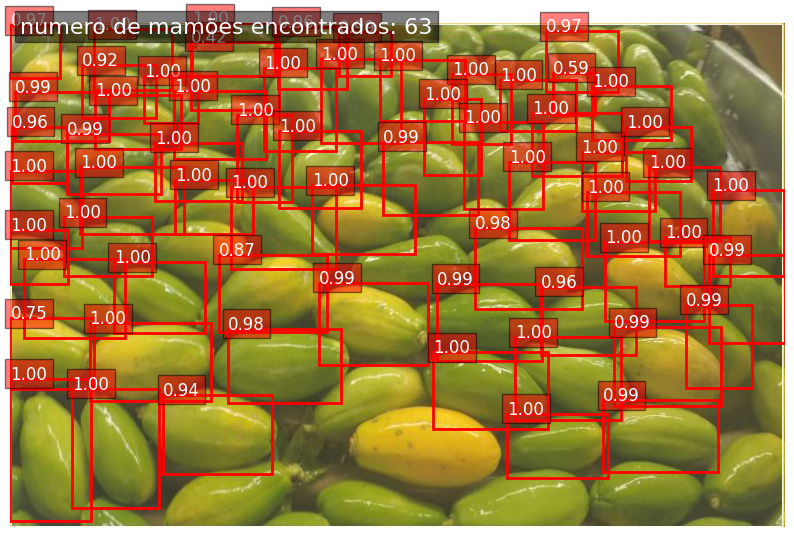

In [28]:
# Perform inference
image_path = r"assets\Teste_Imagem.JPG"
image = load_image(image_path).to(device)
with torch.no_grad():
    predictions = model(image)[0]

# Visualize the predictions
visualize_predictions(image_path, predictions, threshold=0.3)

Vemos alguns erros é verdade, devido as otimizações que ainda podem ser feitas, mas no geral um bom resultado com uma confiança boa do modelo

Ainda poderia ser feito, por exemplo: augmentation dos dados, comparação entre modelos, busca de hyper parametros e treinar por mais tempo.

# Desafio 2


Para o desafio 2, o ideal seria usar um tracker para saber onde está determinado mamão de um frame para o outro, mas estou com pouco tempo para implementar isso e quero utilizar as ferramentas que já fiz. Portanto, vou adotar outra abordagem: vou literalmente criar uma área abaixo da linha e contar quando um mamão sair dessa área, como se ele tivesse passado pela linha.
Para isso funcionar, o detector de objetos precisa ter uma qualidade razoável para evitar "fantasmas". A qualidade do vídeo é boa e, o mais importante, a taxa de frames é alta, o que vai permitir definir uma pequena área de contagem.

In [42]:
import cv2
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import re

Vou repetir isso caso alguem queria rodar a partir daqui

In [30]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)
model.load_state_dict(torch.load("modelos\model_epoch_42.pth"))  
model.eval().to(device)
print("modelo caregado")

modelo caregado


Definido algummas variaveis do codigo

In [40]:
line_y = 1000  # eu so fui chutando a altura da linha
detecting_area = 200 # tamanho da area de contagem
threshold = 0.5 # para as detecções

# Ler o vídeo
cap = cv2.VideoCapture("assets\Teste_Video.mp4")

# Definir o tempo de início e fim da contagem
start_count_time = 5  # segundos
end_count_time = 35  # segundos

frame_counter = 0 # contador de frames
papaya_counter = 0

In [41]:
prev_counter_blue = 0 #usado na logica de contagem
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    frame_counter += 1

    # Obter o tempo atual do vídeo
    current_time = cap.get(cv2.CAP_PROP_POS_MSEC) / 1000.0  # Tempo em segundos

    # Verificar se o tempo atual está dentro do intervalo de contagem
    if start_count_time <= current_time <= (end_count_time - 1):
        # faz algumas alterações no frame para alimentar o modelo
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # muda a ordem das cores
        image_tensor = torch.from_numpy(image).permute(2, 0, 1).float()  # muda a ordem dos canais
        image_tensor /= 255.0  # normaliza
        images = [image_tensor.to(device)]  # passa para uma lista de tensor

        with torch.no_grad():
            predictions = model(images)[0]  # faz a inferencia

        # desenha uma linha por cima da amarela e uma mais abaixo para delimitar a area de contagem
        cv2.line(frame, (0, line_y), (frame.shape[1], line_y), (254, 0, 0), 2)  
        cv2.line(frame, (0, line_y+detecting_area), (frame.shape[1], line_y+detecting_area), (254, 0, 0), 2) 

        counter_blue = 0
        for box, score in zip(predictions['boxes'], predictions['scores']):
            if score >= threshold:
                xmin, ymin, xmax, ymax = box.cpu().numpy().astype(int)

                # Muito importante: pagamos um ponto do meio e embaixo da imagem para considerar como a passagem do mamao
                # isso não é o ideal, mas como a linha amarela atrapalha muito a predição é melhor
                center_x = (xmin + xmax) // 2
                center_y = (ymin + ymax) //2
                # isso gera um problema pois quando o video acaba, alguns mamões que ainda não passaram
                # já foram contados
                # por isso eu achei por bem usar tirar um segundo da contagem de 35 para tentar amenizar esse efeito
                
                if center_y > line_y + detecting_area:
                    color = (0, 255, 0) # ver para quem ainda não foi contado 
                elif center_y <= (line_y + detecting_area) and center_y > line_y:
                    counter_blue += 1 # contamos o objeto na area de contagem
                    color = (255, 0, 0) 
                else:
                    color = (0, 0, 255)

                # Draw the rectangle
                cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), color, 2)  # Red rectangle
                cv2.putText(frame, f'{score:.2f}', (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)

                # Draw the center point
                cv2.circle(frame, (center_x, center_y), 5, color, -1)

        if prev_counter_blue > counter_blue:
            papaya_counter += (prev_counter_blue - counter_blue)
        prev_counter_blue = counter_blue

    cv2.putText(frame, f'mamoes contados: {papaya_counter}', (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 4, (255, 0, 0), 4, cv2.LINE_AA)

    # Display the resulting frame
    cv2.imwrite(f"frames/frames_{frame_counter}.png", frame)

    # Pressione 'q' para sair
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Exibir a contagem final
print(f'Total de mamões que ultrapassaram a linha: {papaya_counter}')

# Liberar os recursos
cap.release()
cv2.destroyAllWindows()


Total de mamões que ultrapassaram a linha: 279


In [44]:
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split(r'(\d+)', s)]

# pasta onde os frames estão
folder_path = 'frames'
# nome do arquivo de saida
output_file = 'output_video_meio.mp4'

fps = 30.0

# lembrar de ordenar os frames
frames = [img for img in os.listdir(folder_path) if img.endswith(('.png', '.jpg', '.jpeg'))]
frames.sort(key=natural_sort_key)

# pega as dimensoes
first_frame = cv2.imread(os.path.join(folder_path, frames[0]))
height, width, layers = first_frame.shape

# cria o codec
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_file, fourcc, fps, (width, height))

# vai colocando os frames no codec
for frame_name in frames:
    frame = cv2.imread(os.path.join(folder_path, frame_name))
    out.write(frame)

# Release the VideoWriter
out.release()
print(f"video criado {output_file}")

video criado output_video_meio.mp4


Esse metodo parece gerar alguns inconsistencias no video, mas o resultado é aceitavel

Foram contados 279 mamões!